In [1]:
%pip install mlxtend kagglehub

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


### Load libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

import shutil
import scipy.stats as stats
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix, RocCurveDisplay, roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler

### Load and sanity-check the data

In [3]:
import kagglehub

# Download latest version
#path = kagglehub.dataset_download("abdulwadood11220/netflix-customer-churn-dataset")

#print("Path to dataset files:", path)

In [ ]:
kaggle_cache_csv = Path(
    r"C:\Users\peace\.cache\kagglehub\datasets\abdulwadood11220"
    r"\netflix-customer-churn-dataset\versions\1\netflix_customer_churn.csv")



In [ ]:
# make project data folder
project_data_dir = Path("data")
project_data_dir.mkdir(exist_ok=True)

destination = project_data_dir / "netflix_customer_churn.csv"
shutil.copy(kaggle_cache_csv, destination)
print(f"Copied dataset to: {destination.resolve()}")

In [4]:
dataset_dir = "c:\\Users\\peace\\.cache\\kagglehub\\datasets\\abdulwadood11220\\netflix-customer-churn-dataset\\versions\\1"
print(os.listdir(dataset_dir))

['netflix_customer_churn.csv']


In [5]:
# Replace with the actual filename
file_path = os.path.join(dataset_dir, "netflix_customer_churn.csv")
df = pd.read_csv(file_path)

In [6]:
# review data
pd.set_option('display.max_columns', None)
print(df.head())

                            customer_id  age  gender subscription_type  \
0  a9b75100-82a8-427a-a208-72f24052884a   51   Other             Basic   
1  49a5dfd9-7e69-4022-a6ad-0a1b9767fb5b   47   Other          Standard   
2  4d71f6ce-fca9-4ff7-8afa-197ac24de14b   27  Female          Standard   
3  d3c72c38-631b-4f9e-8a0e-de103cad1a7d   53   Other           Premium   
4  4e265c34-103a-4dbb-9553-76c9aa47e946   56   Other          Standard   

   watch_hours  last_login_days   region  device  monthly_fee  churned  \
0        14.73               29   Africa      TV         8.99        1   
1         0.70               19   Europe  Mobile        13.99        1   
2        16.32               10     Asia      TV        13.99        0   
3         4.51               12  Oceania      TV        17.99        1   
4         1.89               13   Africa  Mobile        13.99        1   

  payment_method  number_of_profiles  avg_watch_time_per_day favorite_genre  
0      Gift Card                

In [7]:
# sample a few rows
df.sample(5)

,customer_id,age,gender,subscription_type,watch_hours,last_login_days,region,device,monthly_fee,churned,payment_method,number_of_profiles,avg_watch_time_per_day,favorite_genre
4456,1141bdf2-a5e8-4026-9422-d4844620fe61,40,Male,Basic,0.28,37,South America,Desktop,8.99,1,Gift Card,2,0.01,Romance
3730,def3e5b6-5ce0-4d69-b0b5-b39fad417a6d,35,Male,Premium,9.51,2,Oceania,Desktop,17.99,0,Gift Card,1,3.17,Horror
4024,6f60718e-5a94-4ed6-9350-982f44c4166c,48,Female,Premium,10.54,19,Europe,Mobile,17.99,0,Credit Card,1,0.53,Sci-Fi
1760,5dd87c4e-29ae-4eb3-af0c-170f76727f27,54,Female,Basic,39.11,53,South America,Laptop,8.99,0,Gift Card,3,0.72,Horror
3760,f1f834a6-23c4-405a-b5f2-dfd604ce318b,32,Other,Premium,5.09,37,Oceania,Desktop,17.99,0,Credit Card,5,0.13,Drama


In [8]:
# review data structure
df.info()

# drop the customer id column
df = df.drop(columns=['customer_id'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   customer_id             5000 non-null   object 
 1   age                     5000 non-null   int64  
 2   gender                  5000 non-null   object 
 3   subscription_type       5000 non-null   object 
 4   watch_hours             5000 non-null   float64
 5   last_login_days         5000 non-null   int64  
 6   region                  5000 non-null   object 
 7   device                  5000 non-null   object 
 8   monthly_fee             5000 non-null   float64
 9   churned                 5000 non-null   int64  
 10  payment_method          5000 non-null   object 
 11  number_of_profiles      5000 non-null   int64  
 12  avg_watch_time_per_day  5000 non-null   float64
 13  favorite_genre          5000 non-null   object 
dtypes: float64(3), int64(4), object(7)
memor

In [9]:
# descriptive statistics for numerical features
df.describe()

# can see some outliers in watch_hours and avg_watch_time_per_day which is to be expected; candidates for log transformation

,age,watch_hours,last_login_days,monthly_fee,churned,number_of_profiles,avg_watch_time_per_day
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,43.847400,11.649450,30.089800,13.683400,0.503000,3.024400,0.874800
std,15.501128,12.014654,17.536078,3.692062,0.500041,1.415841,2.619824
min,18.000000,0.010000,0.000000,8.990000,0.000000,1.000000,0.000000
25%,30.000000,3.337500,15.000000,8.990000,0.000000,2.000000,0.110000
50%,44.000000,8.000000,30.000000,13.990000,1.000000,3.000000,0.290000
75%,58.000000,16.030000,45.000000,17.990000,1.000000,4.000000,0.720000
max,70.000000,110.400000,60.000000,17.990000,1.000000,5.000000,98.420000


In [10]:
# descriptive statistics for categorical features
df.describe(include='object')

# can see that most customers are female, have a premium subscription, reside in South America, use their tablets, pay with debit card and prefer the Drama genre.

,gender,subscription_type,region,device,payment_method,favorite_genre
count,5000,5000,5000,5000,5000,5000
unique,3,3,6,5,5,7
top,Female,Premium,South America,Tablet,Debit Card,Drama
freq,1711,1693,873,1048,1030,731


In [11]:
# check for na values
df.isna().sum()

age                       0
gender                    0
subscription_type         0
watch_hours               0
last_login_days           0
region                    0
device                    0
monthly_fee               0
churned                   0
payment_method            0
number_of_profiles        0
avg_watch_time_per_day    0
favorite_genre            0
dtype: int64

In [12]:
# check for duplicates
df.duplicated().sum()

np.int64(0)

# Exploratory Data Analysis



*   **Univariate Analysis**
  1.   Categorical features: Barplots
  2.   Numerical features: Histograms (w/ KDE) and Boxplots/Violinplots


*   **Bivariate Analysis**
  1.   Categorical vs Target: Heatmap of crosstabs
  2.   Numerical vs Target: Boxplots/Violinplots or Swarm plots
  3.   Numeric vs Numeric: Hexbin plots  
  4.   Behavioral relationships with Target: binned churn-rate curves
  5.   Effect size: mean diffs/ SMD (standardized mean diffs) 



*   **Correlation Analysis**



*  **Association Rule Mining**






In [13]:
# list categorical columns
df.select_dtypes(include='object').columns.tolist()

['gender',
 'subscription_type',
 'region',
 'device',
 'payment_method',
 'favorite_genre']

In [14]:
# list numerical columns
df.select_dtypes(include='number').columns.tolist()

['age',
 'watch_hours',
 'last_login_days',
 'monthly_fee',
 'churned',
 'number_of_profiles',
 'avg_watch_time_per_day']

## Univariate Analysis

  1.   Categorical features: Barplots
  2.   Numerical features: Histograms (w/ KDE) and Boxplots/Violinplots

  
### Categorical features:

The categorical features are fairly uniform in their distributions, with most categories being equally represented (generally speaking).

### Numerical features:

Similar to the categorical features, most of the numerical features are also uniformly distributed but a few like watch_hours and avg_watch_time_per_day are right skewed.



In [15]:
# cat features
cat_features = df.select_dtypes(include='object').columns.tolist()

# num features
num_features = df.select_dtypes(include='number').columns.tolist()

### Barplots for categorical features

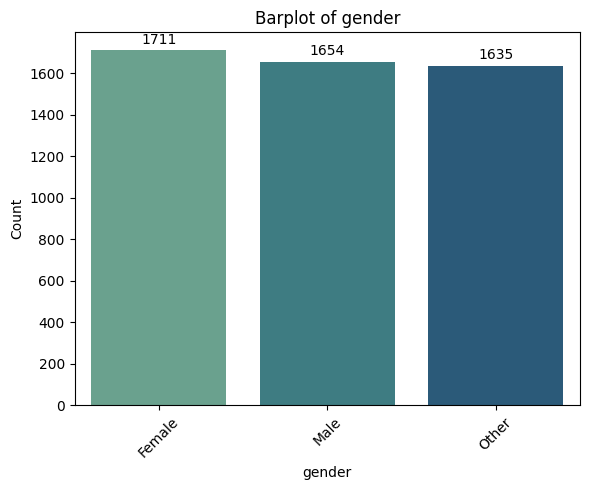

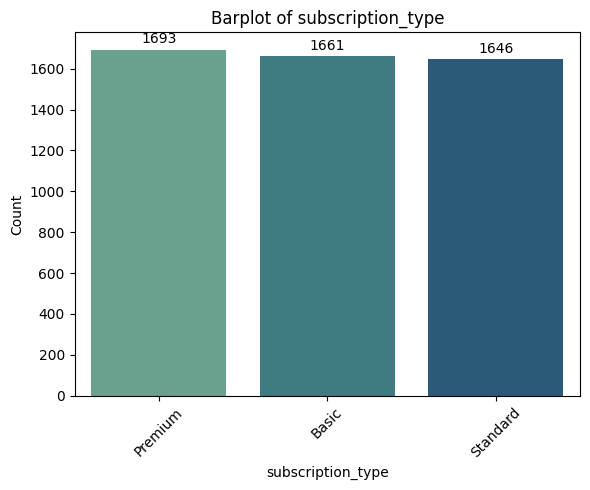

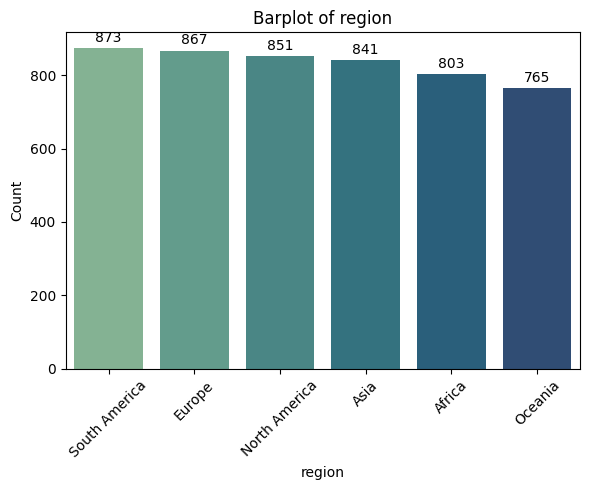

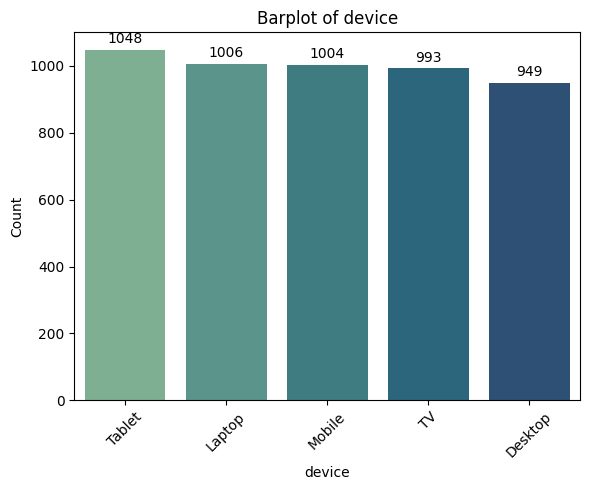

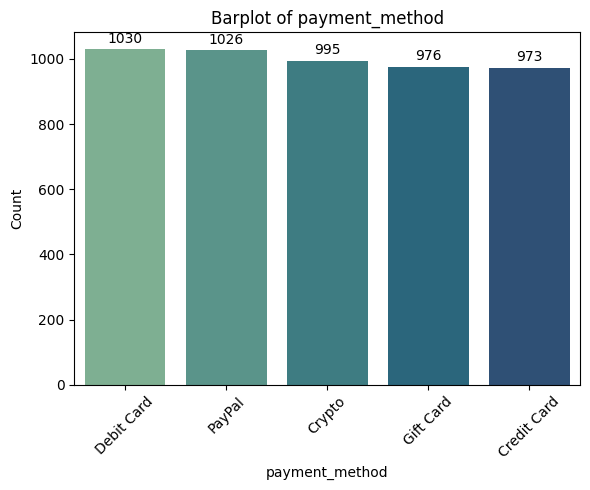

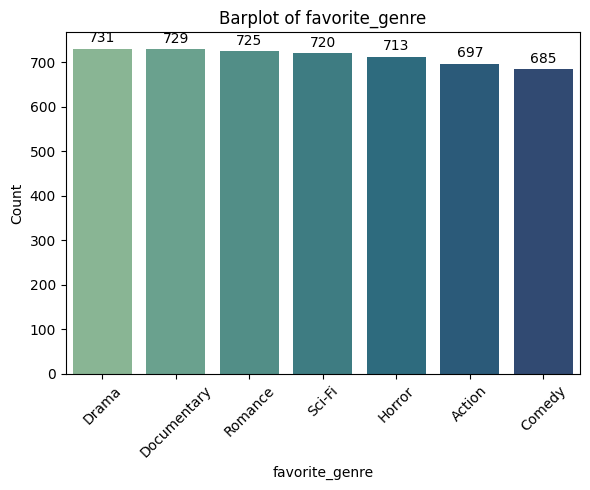

In [16]:
# create barplots for categorical features
for feature in cat_features:
    plt.figure(figsize=(6,5))
    value_counts = df[feature].value_counts()
    x = value_counts.index
    y = value_counts.values
    colors = sns.color_palette("crest", len(x))  # "husl", "Set2", or "tab10" are good options
    ax = sns.barplot(x=x, y=y, palette=colors)

    # Add annotations on top of each bar
    for i, value in enumerate(y):
        ax.text(i, value + max(y)*0.01, str(value), ha='center', va='bottom', fontsize=10)

    plt.title(f'Barplot of {feature}')
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

### Histograms for numerical features

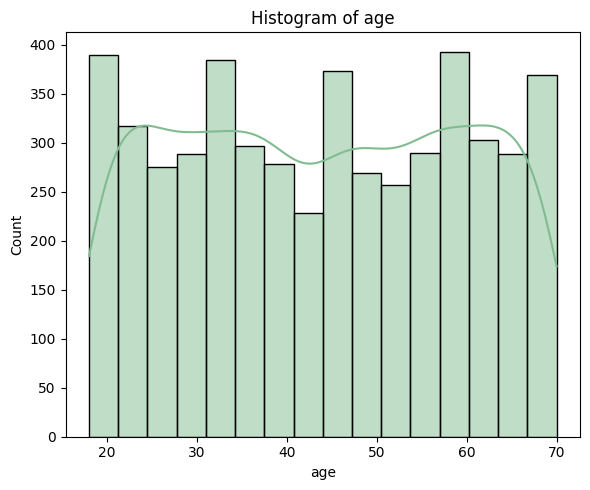

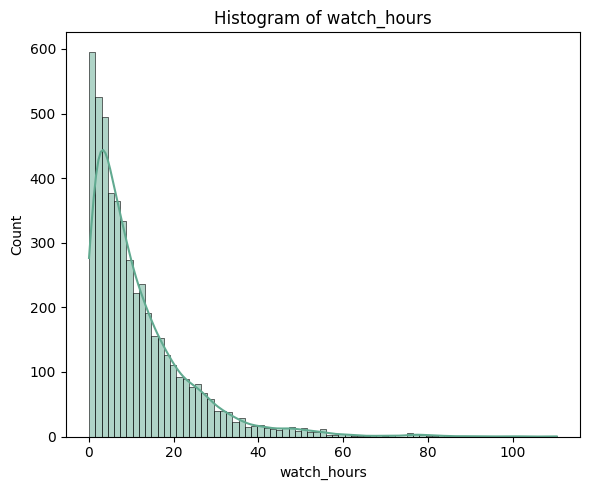

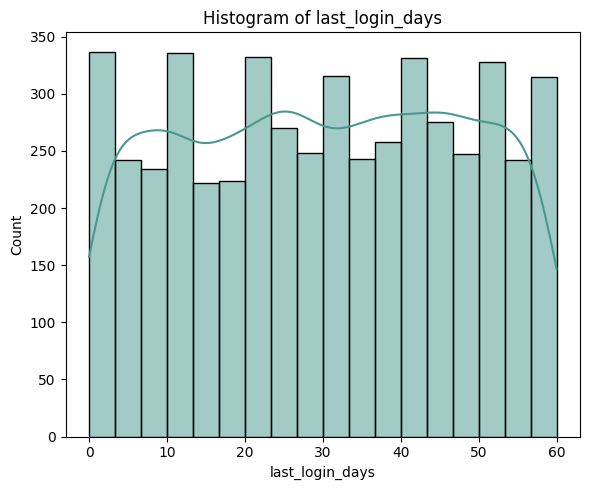

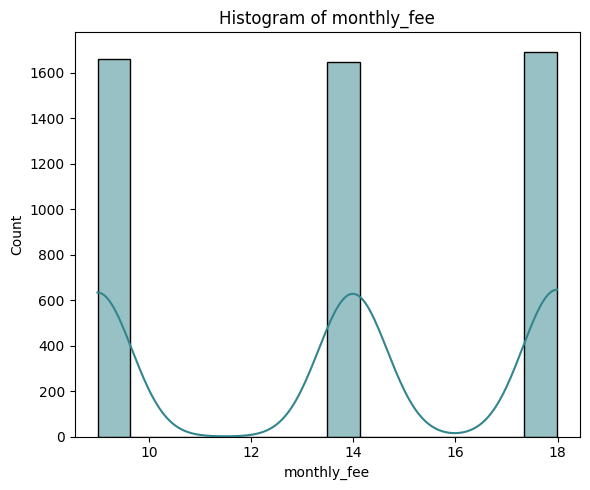

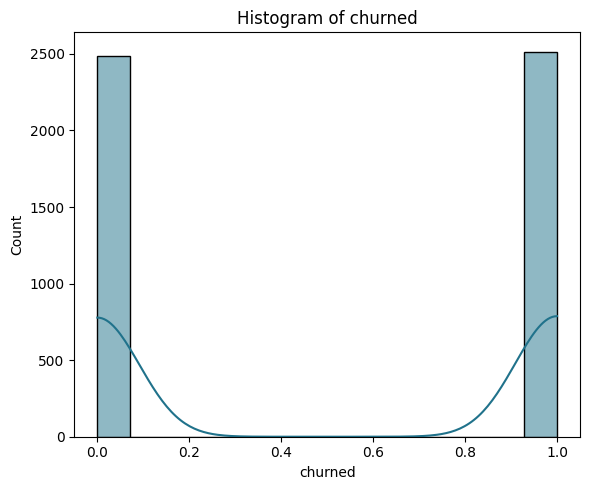

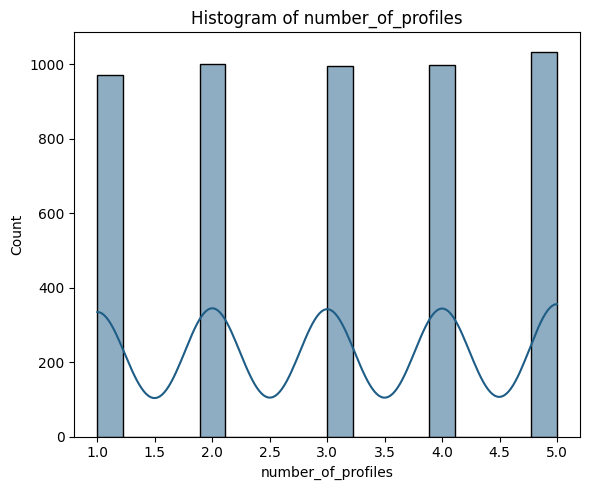

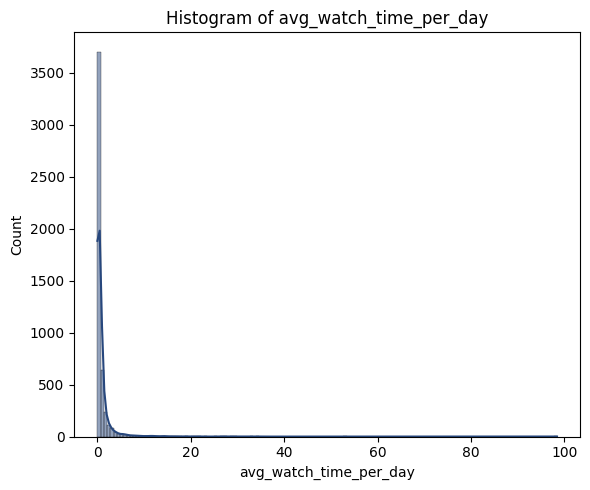

In [17]:
# create histograms for numerical features
colors = sns.color_palette("crest", len(num_features))

for i, feature in enumerate(num_features):
    plt.figure(figsize=(6,5))
    sns.histplot(df[feature], kde=True, color=colors[i])
    plt.title(f'Histogram of {feature}')
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

  # Bivariate Analysis

  
  1.   Categorical vs Target: Heatmap of crosstabs
  2.   Numerical vs Target: Boxplots/Violinplots or Swarm plots
  3.   Numeric vs Numeric: Hexbin plots for engagement features
  4.   Behavioral relationships with Target: binned churn-rate curves
  5.   Effect size: mean diffs/ SMD (standardized mean diffs) 


### Categorical features:
When looking at the categorical features vs the target ("churned"), we can see:
- Women tend to churn more, with those listed as "other" churning the least.
- Customers with the basic subscription churned the most, while those with the premium subscription churned the least.
- The regions that churned the most were Europe and South America, while Africa and North America churned the least.
- Customers using laptops and mobile devices churned the most, while those using desktops and TVs churned the least.
- Customers who paid with crypto and gift cards churned the most, while those paying with credit and debit cards churned the least.
- The most popular genres for customers who churned in action, drama and horror; the most popular generes for non-churned customers are sci-fi, romance and comedy.


### Heatmaps for categorical features by target

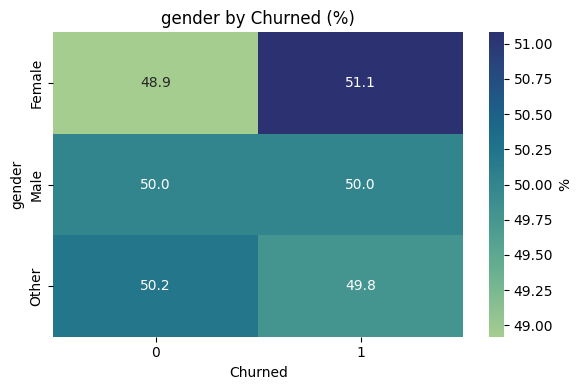

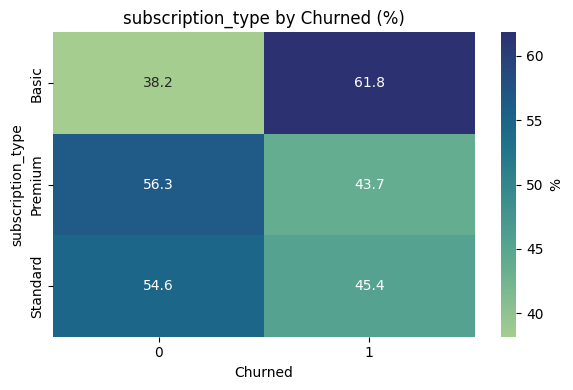

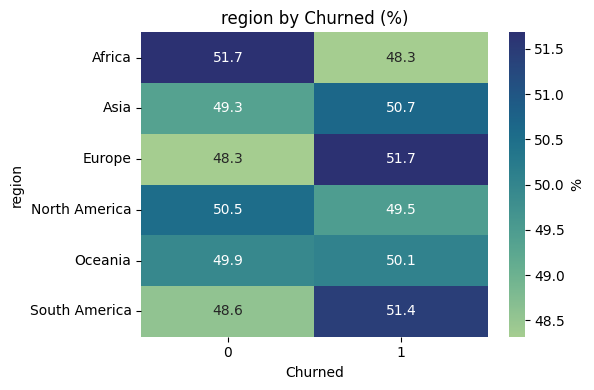

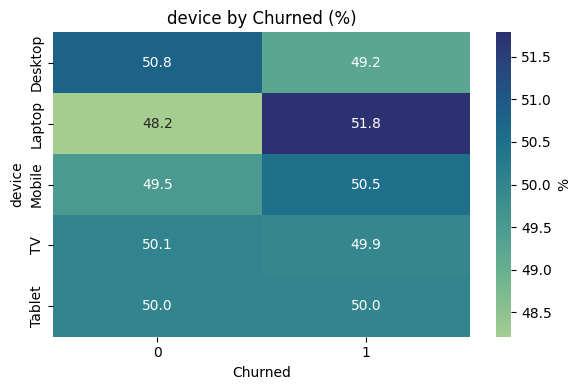

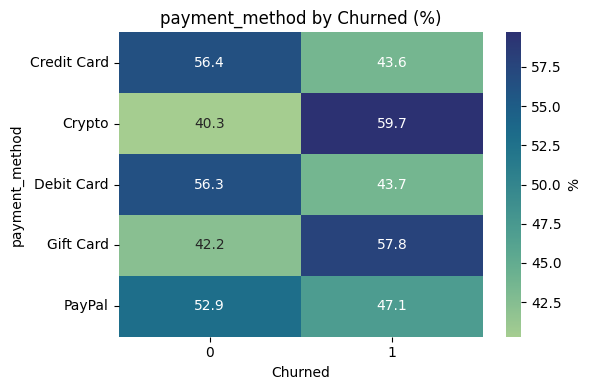

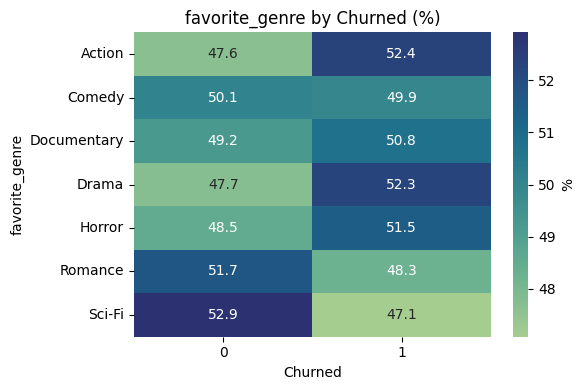

In [18]:
# create heatmaps
for feature in cat_features:
    if feature != 'churned':  # Exclude 'churn' from the heatmap
        ct = pd.crosstab(df[feature], df['churned'], normalize='index') * 100  # row-wise %
        plt.figure(figsize=(6,4))
        sns.heatmap(ct, annot=True, fmt=".1f", cmap="crest", cbar_kws={'label': '%'}) #"YlGnBu
        plt.title(f'{feature} by Churned (%)')
        plt.ylabel(feature)
        plt.xlabel("Churned")
        plt.tight_layout()
        plt.show()

### Numerical features: Need to do this section
When looking at the categorical features vs the target ("churned"), we can see:
- Women tend to churn more, with those listed as "other" churning the least.
- Customers with the basic subscription churned the most, while those with the premium subscription churned the least.
- The regions that churned the most were Europe and South America, while Africa and North America churned the least.
- Customers using laptops and mobile devices churned the most, while those using desktops and TVs churned the least.
- Customers who paid with crypto and gift cards churned the most, while those paying with credit and debit cards churned the least.
- The most popular genres for customers who churned in action, drama and horror; the most popular generes for non-churned customers are sci-fi, romance and comedy.

### Violin plots for numerical features by target

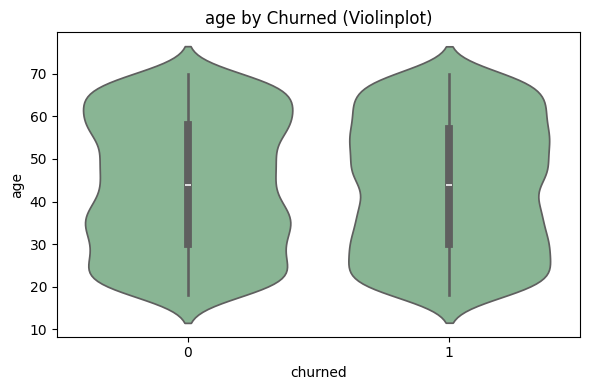

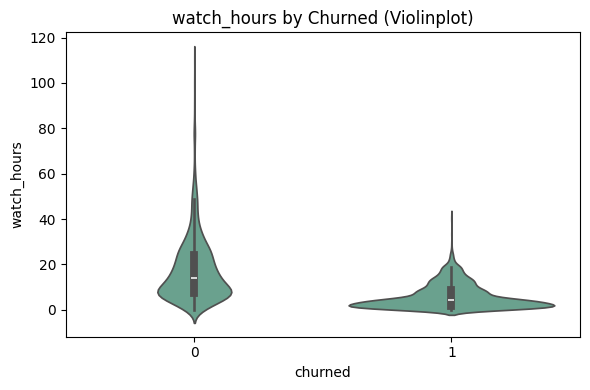

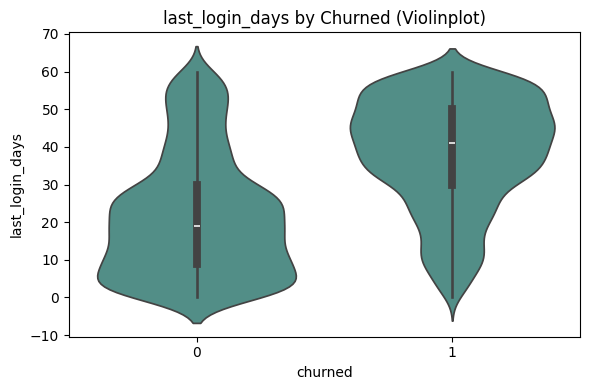

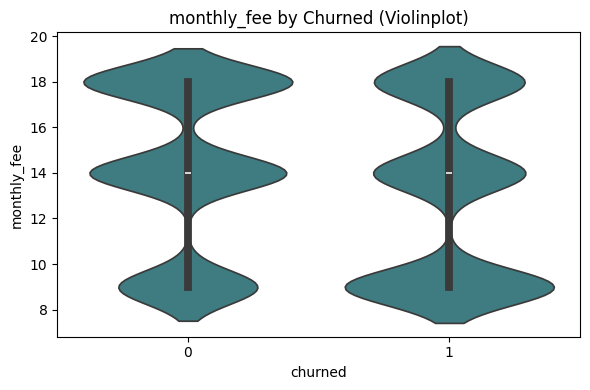

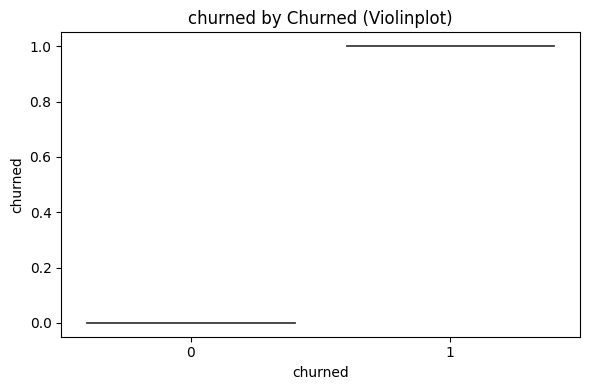

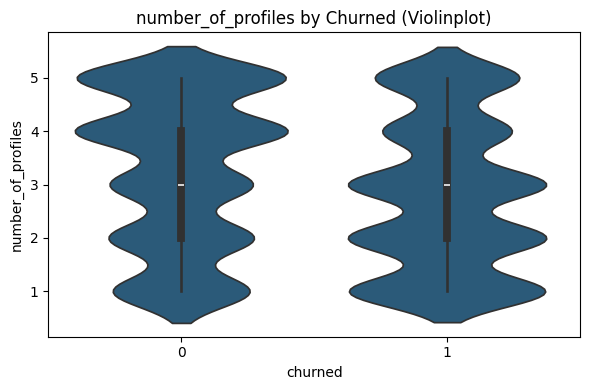

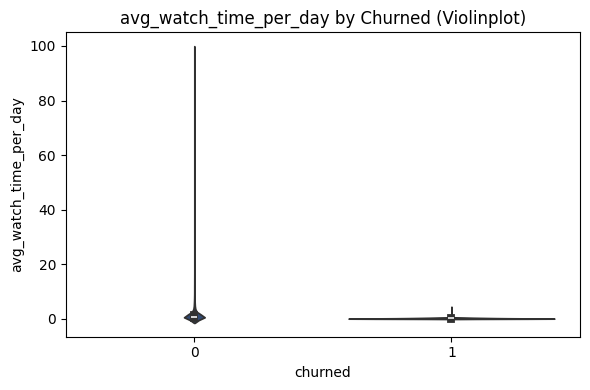

In [19]:
# create violinplots for the numerical features
colors = sns.color_palette("crest", len(num_features))

for feature in num_features:
    plt.figure(figsize=(6,4))
    sns.violinplot(data=df, x='churned', y=feature, color=colors[num_features.index(feature) % len(colors)])
    plt.title(f'{feature} by Churned (Violinplot)')
    plt.tight_layout()
    plt.show()

### Hexbin plots for numerical engagement features

In [20]:
# create hexbin pairs for engagement features
hexbin_pairs = [
    ("watch_hours", "avg_watch_time_per_day"),
    ("watch_hours", "last_login_days"),
    ("monthly_fee", "watch_hours"),
]

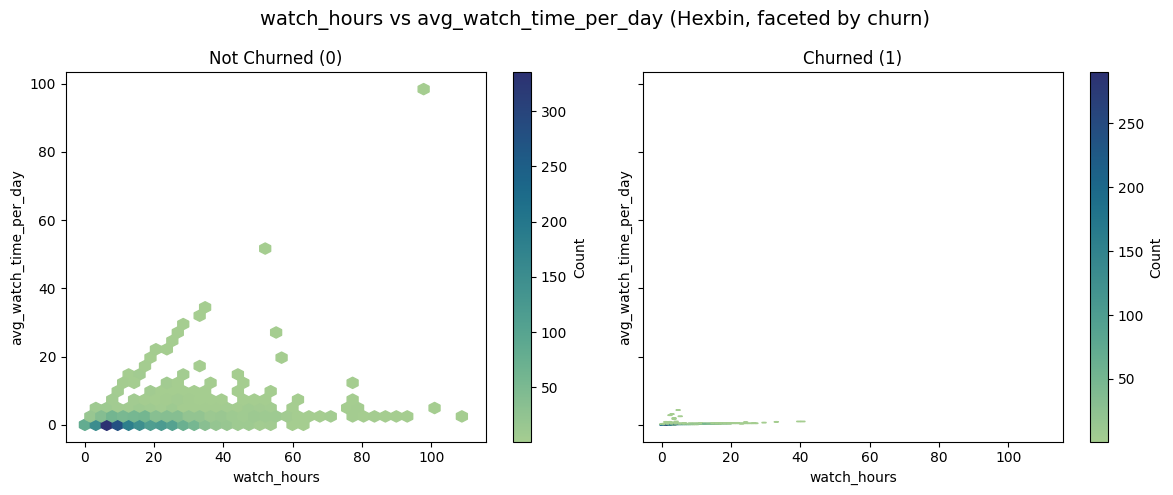

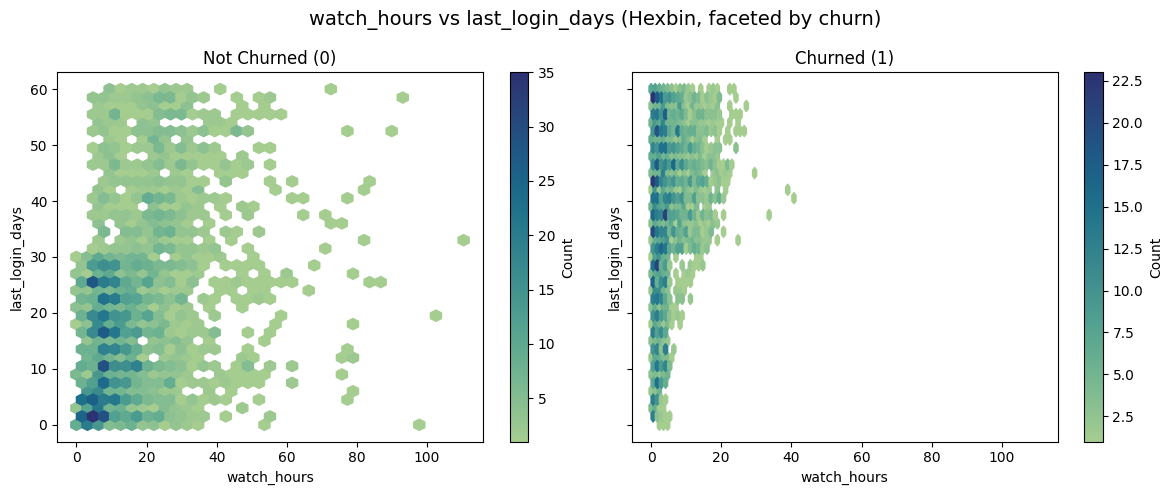

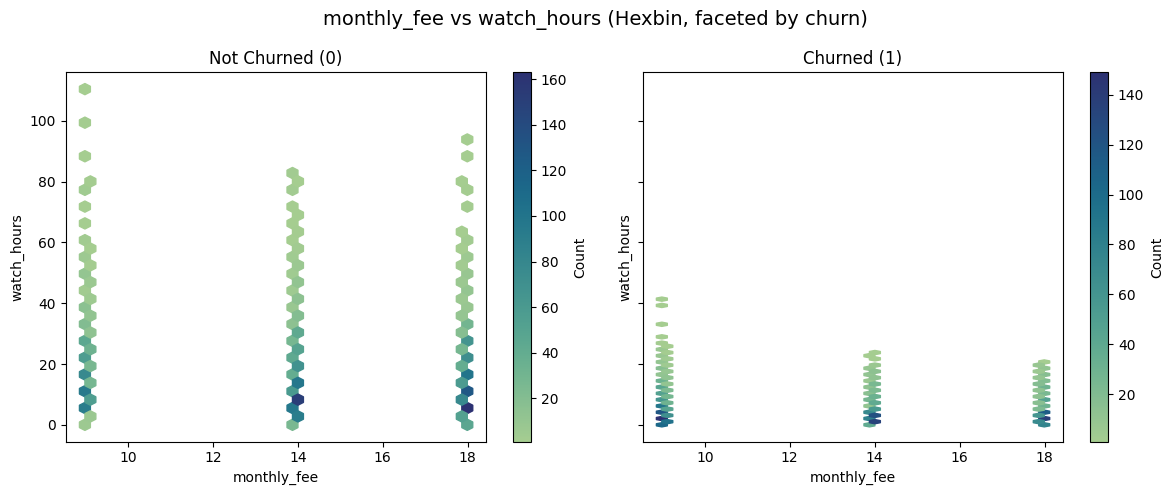

In [21]:
# create hexbin plots
cmap = sns.color_palette("crest", as_cmap=True)

for x, y in hexbin_pairs:
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

    for ax, churn_val, title in zip(axes,[0, 1],["Not Churned (0)", "Churned (1)"]):
        sub = df[df["churned"] == churn_val]
        hb = ax.hexbin(sub[x],sub[y], gridsize=35, mincnt=1, cmap=cmap)
        ax.set_title(title)
        ax.set_xlabel(x)
        ax.set_ylabel(y)
        cb = fig.colorbar(hb, ax=ax)
        cb.set_label("Count")

    fig.suptitle(f"{x} vs {y} (Hexbin, faceted by churn)", fontsize=14)
    plt.tight_layout()
    plt.show()

### Line plots (churn-rate curves) for numerical features

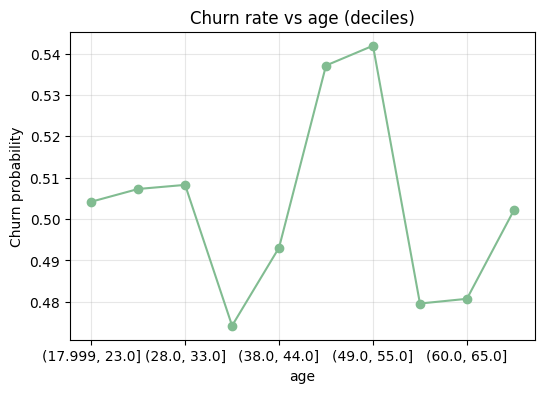

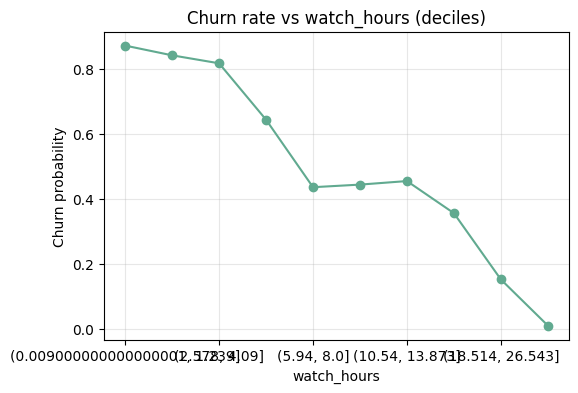

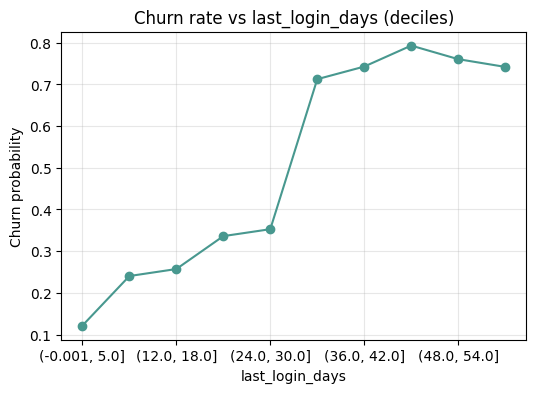

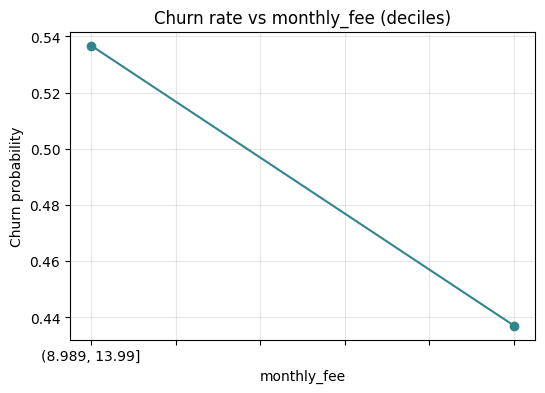

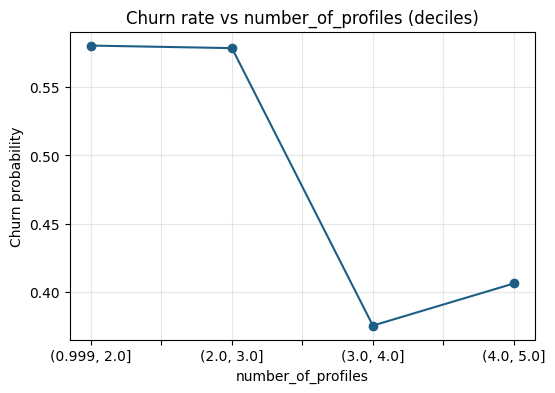

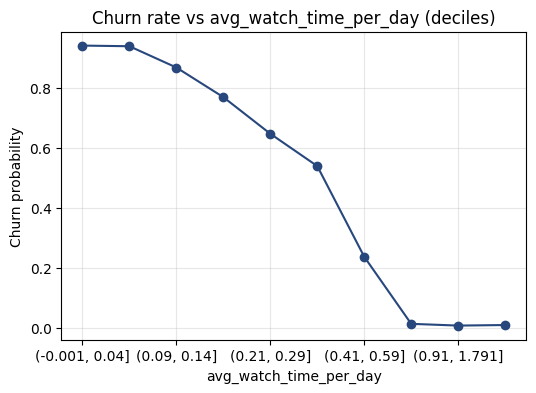

In [22]:
# create line plots/churn-rate curves for numerical features
# binned churn-rate curves: “How does churn probability change as the feature increases?”
colors = sns.color_palette("crest", len(num_features))

for col in num_features:
    if col != 'churned':
        bins = pd.qcut(df[col], q=10, duplicates="drop")
        churn_rate = df.groupby(bins)["churned"].mean()
        churn_rate.plot(marker="o", figsize=(6,4), color=colors[num_features.index(col) % len(colors)])
        plt.title(f"Churn rate vs {col} (deciles)")
        plt.ylabel("Churn probability")
        plt.xlabel(col)
        plt.grid(alpha=0.3)
        plt.show()

### Bar(h) plots for numerical features
# create line plots/churn-rate curves for numerical features
# binned churn-rate curves: “How does churn probability change as the feature increases?”

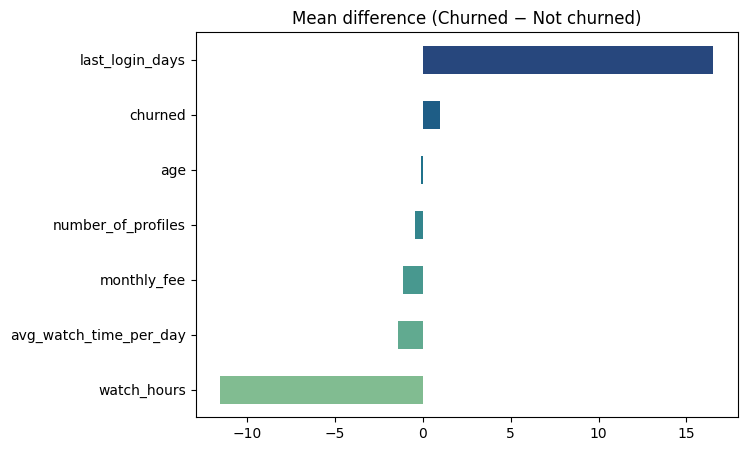

In [23]:
diffs = []
colors = sns.color_palette("crest", len(num_features))

for col in num_features:

        mean_0 = df.loc[df.churned == 0, col].mean()
        mean_1 = df.loc[df.churned == 1, col].mean()
        diffs.append(mean_1 - mean_0)

pd.Series(diffs, index=num_features).sort_values().plot(
    kind="barh", figsize=(7,5), color=colors, legend=False
)
plt.title("Mean difference (Churned − Not churned)")
plt.show()

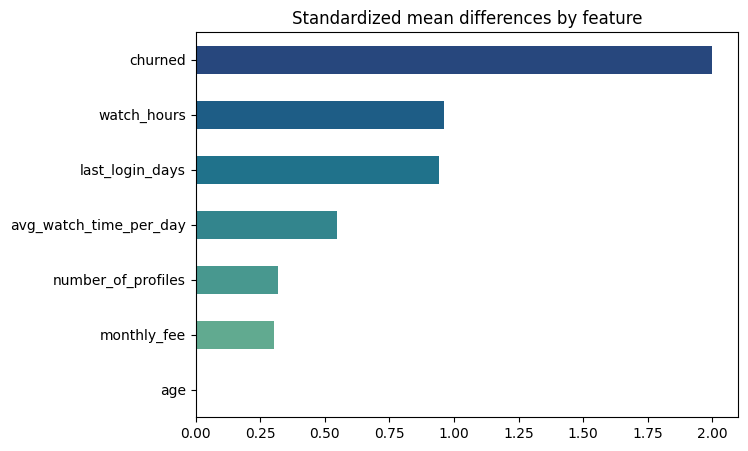

In [24]:
from scipy.stats import zscore

smd = {}
colors = sns.color_palette("crest", len(num_features))

for col in num_features:
    m0 = df.loc[df.churned == 0, col].mean()
    m1 = df.loc[df.churned == 1, col].mean()
    sd = df[col].std()
    smd[col] = (m1 - m0) / sd

pd.Series(smd).abs().sort_values().plot(kind="barh", figsize=(7,5), color=colors, legend=False)
plt.title("Standardized mean differences by feature")
plt.show()

### Correlation analysis: Need to do this section
When looking at the categorical features vs the target ("churned"), we can see:
- Women tend to churn more, with those listed as "other" churning the least.
- Customers with the basic subscription churned the most, while those with the premium subscription churned the least.
- The regions that churned the most were Europe and South America, while Africa and North America churned the least.
- Customers using laptops and mobile devices churned the most, while those using desktops and TVs churned the least.
- Customers who paid with crypto and gift cards churned the most, while those paying with credit and debit cards churned the least.
- The most popular genres for customers who churned in action, drama and horror; the most popular generes for non-churned customers are sci-fi, romance and comedy.

In [25]:
df.head()

,age,gender,subscription_type,watch_hours,last_login_days,region,device,monthly_fee,churned,payment_method,number_of_profiles,avg_watch_time_per_day,favorite_genre
0,51,Other,Basic,14.73,29,Africa,TV,8.99,1,Gift Card,1,0.49,Action
1,47,Other,Standard,0.70,19,Europe,Mobile,13.99,1,Gift Card,5,0.03,Sci-Fi
2,27,Female,Standard,16.32,10,Asia,TV,13.99,0,Crypto,2,1.48,Drama
3,53,Other,Premium,4.51,12,Oceania,TV,17.99,1,Crypto,2,0.35,Horror
4,56,Other,Standard,1.89,13,Africa,Mobile,13.99,1,Crypto,2,0.13,Action


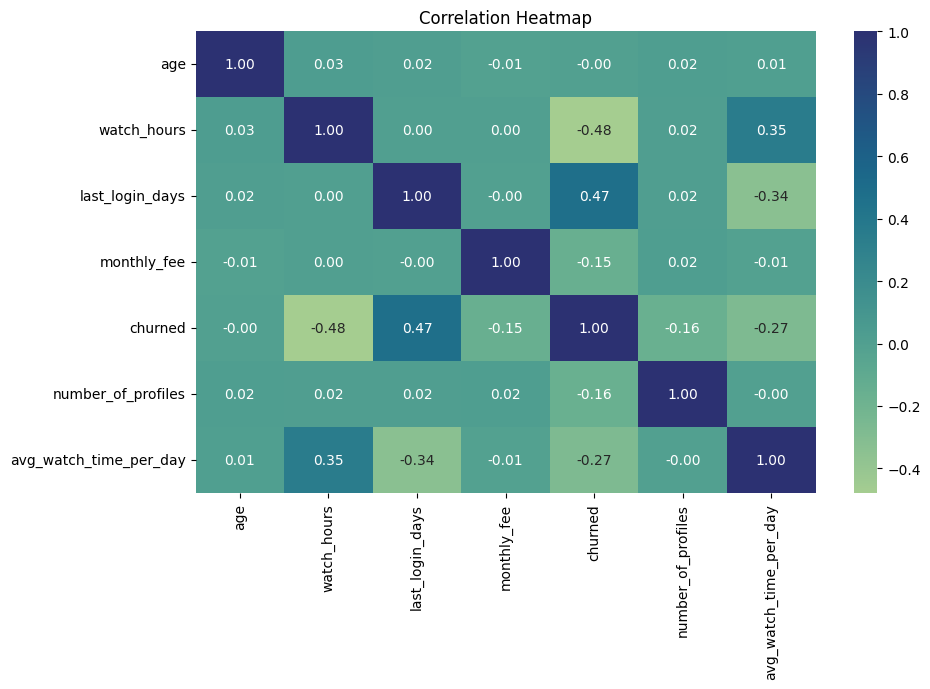

In [26]:
# create correlation heatmap
df_corr = df.copy()
corr = df_corr.corr(numeric_only=True)


plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True, cmap='crest', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

### Association Rule Mining

In [27]:
# review column list
df.columns.to_list()

['age',
 'gender',
 'subscription_type',
 'watch_hours',
 'last_login_days',
 'region',
 'device',
 'monthly_fee',
 'churned',
 'payment_method',
 'number_of_profiles',
 'avg_watch_time_per_day',
 'favorite_genre']

In [ ]:
# define arm numerical features
arm_cat_features = df[cat_features].copy()
arm_num_features = df[num_features].copy()

# bin numerical features before ohe
arm_num_features['age_bin'] = pd.cut(arm_num_features['age'], bins=[0, 18, 25, 35, 45, 55, 65, 100], labels=['<18', '18-24', '25-34', '35-44', '45-54', '55-64', '65+'])
arm_num_features['watch_hours_bin'] = pd.qcut(arm_num_features['watch_hours'], q=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
arm_num_features['avg_watch_time_per_day_bin'] = pd.qcut(arm_num_features['avg_watch_time_per_day'], q=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
arm_num_features['last_login_days_bin'] = pd.qcut(arm_num_features['last_login_days'], q=5, labels=['0-3', '4-7', '8-14', '15-30', '31+'])
#arm_num_features['monthly_fee_bin'] = pd.qcut(arm_num_features['monthly_fee'], q=3,  duplicates='drop')   
arm_num_features['number_of_profiles_bin'] = pd.cut(arm_num_features['number_of_profiles'], bins=[0, 1, 2, 3, 4, 5], labels=['1', '2', '3', '4', '5'], include_lowest=True)

In [ ]:
fee_bins = pd.qcut(arm_num_features['monthly_fee'], q=3, duplicates='drop', retbins=True)
arm_num_features['monthly_fee_bin'] = fee_bins[0]
n_fee_bins = len(fee_bins[1]) - 1
fee_labels_map = {1: ['Fee_Bin1'], 2: ['Basic', 'Premium'], 3: ['Basic', 'Standard', 'Premium']}

arm_num_features['monthly_fee_bin'] = pd.qcut(arm_num_features['monthly_fee'], q=min(3, n_fee_bins), labels=fee_labels_map[n_fee_bins], duplicates='drop')
num_bin_cols = [
    'age_bin','watch_hours_bin','avg_watch_time_per_day_bin',
    'last_login_days_bin','monthly_fee_bin','number_of_profiles_bin'
]
arm_num_bins = arm_num_features[num_bin_cols].copy()

In [48]:
# ohe numerical and categorical features
arm_num = pd.get_dummies(arm_num_bins, prefix_sep='=')
arm_cat = pd.get_dummies(arm_cat_features, prefix_sep='=')

# concatenate numerical and categorical features
arm_df = pd.concat([arm_num, arm_cat], axis=1).astype(bool)
print(arm_df.head())

   age_bin=<18  age_bin=18-24  age_bin=25-34  age_bin=35-44  age_bin=45-54  \
0        False          False          False          False           True   
1        False          False          False          False           True   
2        False          False           True          False          False   
3        False          False          False          False           True   
4        False          False          False          False          False   

   age_bin=55-64  age_bin=65+  watch_hours_bin=Very Low  watch_hours_bin=Low  \
0          False        False                     False                False   
1          False        False                      True                False   
2          False        False                     False                False   
3          False        False                     False                 True   
4           True        False                      True                False   

   watch_hours_bin=Medium  watch_hours_bin=High  w

In [50]:
# create frequent itemsets
frequent_itemsets = apriori(arm_df, min_support=0.02, use_colnames=True, max_len=3)
frequent_itemsets.sort_values(by='support', ascending=False).head(20)

,support,itemsets
22,0.6614,(monthly_fee_bin=Basic)
29,0.3422,(gender=Female)
23,0.3386,(monthly_fee_bin=Premium)
33,0.3386,(subscription_type=Premium)
966,0.3386,"(subscription_type=Premium, monthly_fee_bin=Pr..."
933,0.3322,"(monthly_fee_bin=Basic, subscription_type=Basic)"
32,0.3322,(subscription_type=Basic)
30,0.3308,(gender=Male)
934,0.3292,"(monthly_fee_bin=Basic, subscription_type=Stan..."
34,0.3292,(subscription_type=Standard)


In [51]:
rules = association_rules(frequent_itemsets, metric='lift', min_threshold=1.0)
rules.sort_values(['lift','confidence'], ascending=False).head(20)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
2854,(avg_watch_time_per_day_bin=Low),"(last_login_days_bin=31+, watch_hours_bin=Medium)",0.1930,0.0384,0.0384,0.198964,5.181347,1.0,0.030989,1.200445,1.000000,0.198964,0.166976,0.599482
2849,"(last_login_days_bin=31+, watch_hours_bin=Medium)",(avg_watch_time_per_day_bin=Low),0.0384,0.1930,0.0384,1.000000,5.181347,1.0,0.030989,inf,0.839226,0.198964,1.000000,0.599482
3387,"(watch_hours_bin=Very High, last_login_days_bi...",(avg_watch_time_per_day_bin=Very High),0.0420,0.1980,0.0420,1.000000,5.050505,1.0,0.033684,inf,0.837161,0.212121,1.000000,0.606061
3388,(avg_watch_time_per_day_bin=Very High),"(watch_hours_bin=Very High, last_login_days_bi...",0.1980,0.0420,0.0420,0.212121,5.050505,1.0,0.033684,1.215923,1.000000,0.212121,0.177580,0.606061
3186,(avg_watch_time_per_day_bin=Very High),"(watch_hours_bin=High, last_login_days_bin=0-3)",0.1980,0.0424,0.0420,0.212121,5.002859,1.0,0.033605,1.215415,0.997649,0.211694,0.177236,0.601344
3185,"(watch_hours_bin=High, last_login_days_bin=0-3)",(avg_watch_time_per_day_bin=Very High),0.0424,0.1980,0.0420,0.990566,5.002859,1.0,0.033605,85.012000,0.835541,0.211694,0.988237,0.601344
2241,"(last_login_days_bin=4-7, avg_watch_time_per_d...",(watch_hours_bin=Very Low),0.0312,0.2000,0.0312,1.000000,5.000000,1.0,0.024960,inf,0.825764,0.156000,1.000000,0.578000
3340,"(last_login_days_bin=31+, avg_watch_time_per_d...",(watch_hours_bin=Very High),0.0256,0.2000,0.0256,1.000000,5.000000,1.0,0.020480,inf,0.821018,0.128000,1.000000,0.564000
3343,(watch_hours_bin=Very High),"(last_login_days_bin=31+, avg_watch_time_per_d...",0.2000,0.0256,0.0256,0.128000,5.000000,1.0,0.020480,1.117431,1.000000,0.128000,0.105090,0.564000
2246,(watch_hours_bin=Very Low),"(last_login_days_bin=4-7, avg_watch_time_per_d...",0.2000,0.0312,0.0312,0.156000,5.000000,1.0,0.024960,1.147867,1.000000,0.156000,0.128819,0.578000


In [ ]:
"""frequent_itemsets = apriori(arm_df, min_support=0.02, use_colnames=True)
frequent_itemsets.sort_values(by="support", ascending=False).head(20)"""

c:\Users\peace\AppData\Local\Programs\Python\Python313\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:175: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


ValueError: The allowed values for a DataFrame are True, False, 0, 1. Found value 51

In [119]:
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.01)
rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values(by='lift', ascending=False).head()
rules[rules['consequents'].astype(str).str.contains('churned')].head(50)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
38,(gender_Male),(churned),0.3308,0.5030,0.1654,0.500000,0.994036,1.0,-0.000992,0.994000,-0.008886,0.247457,-0.006036,0.414414
78,(gender_Other),(churned),0.3270,0.5030,0.1628,0.497859,0.989780,1.0,-0.001681,0.989762,-0.015111,0.244005,-0.010343,0.410759
108,(region_Asia),(churned),0.1682,0.5030,0.0852,0.506540,1.007037,1.0,0.000595,1.007173,0.008401,0.145392,0.007122,0.337962
138,(region_Europe),(churned),0.1734,0.5030,0.0896,0.516724,1.027285,1.0,0.002380,1.028399,0.032132,0.152693,0.027614,0.347428
168,(region_North America),(churned),0.1702,0.5030,0.0842,0.494712,0.983523,1.0,-0.001411,0.983598,-0.019790,0.142954,-0.016676,0.331054
197,(region_Oceania),(churned),0.1530,0.5030,0.0766,0.500654,0.995335,1.0,-0.000359,0.995301,-0.005503,0.132206,-0.004721,0.326470
226,(region_South America),(churned),0.1746,0.5030,0.0898,0.514318,1.022502,1.0,0.001976,1.023304,0.026662,0.152773,0.022774,0.346424
248,(device_Laptop),(churned),0.2012,0.5030,0.1042,0.517893,1.029608,1.0,0.002996,1.030891,0.035999,0.173667,0.029965,0.362525
270,(device_Mobile),(churned),0.2008,0.5030,0.1014,0.504980,1.003937,1.0,0.000398,1.004000,0.004906,0.168327,0.003984,0.353285
292,(device_TV),(churned),0.1986,0.5030,0.0992,0.499496,0.993035,1.0,-0.000696,0.993000,-0.008676,0.164675,-0.007049,0.348357


In [120]:
# select only the rules where churned is the only consequent
rules_to_churn = rules[
    (rules['consequents'] == frozenset({'churned'})) &
    (rules['antecedents'].apply(lambda x: len(x) > 1))
]

# sort by lift or confidence
top_20 = rules_to_churn.sort_values(by='lift', ascending=False).head(20)[
    ['antecedents', 'consequents', 'support', 'confidence', 'lift']
]
top_20

,antecedents,consequents,support,confidence,lift
606,"(region_Europe, payment_method_Gift Card)",(churned),0.0222,0.664671,1.321413
600,"(region_Asia, payment_method_Crypto)",(churned),0.0226,0.645714,1.283726
660,"(payment_method_Crypto, device_TV)",(churned),0.0254,0.638191,1.268769
648,"(device_Mobile, payment_method_Crypto)",(churned),0.0238,0.616580,1.225806
612,"(region_North America, payment_method_Crypto)",(churned),0.0216,0.613636,1.219953
624,"(payment_method_Crypto, region_South America)",(churned),0.0228,0.609626,1.211979
684,"(favorite_genre_Horror, payment_method_Crypto)",(churned),0.0200,0.602410,1.197633
654,"(device_Mobile, payment_method_Gift Card)",(churned),0.0238,0.597990,1.188847
438,"(gender_Male, payment_method_Crypto)",(churned),0.0356,0.597315,1.187506
636,"(payment_method_Gift Card, device_Laptop)",(churned),0.0240,0.597015,1.186908


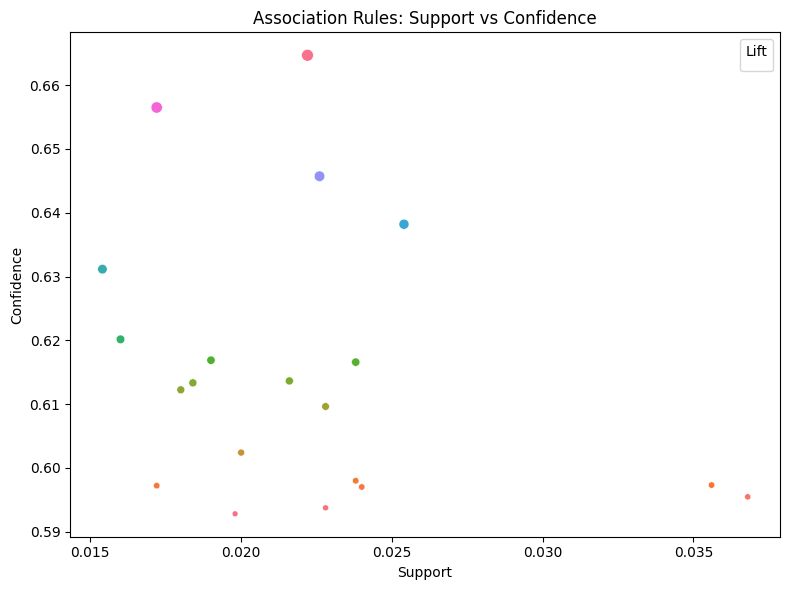

In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=top_20, x='support', y='confidence', size='lift', hue='lift', palette='crest', legend=False)
plt.title('Association Rules: Support vs Confidence')
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.tight_layout()
plt.legend(title='Lift')
plt.show()

In [ ]:
#extra arm code from other file
# define arm numerical features
arm_cat_features = df[cat_features].copy()
arm_num_features = df[num_features].copy()

# bin numerical features before ohe
arm_num_features['age_bin'] = pd.cut(arm_num_features['age'], bins=[0, 18, 25, 35, 45, 55, 65, 100], labels=['<18', '18-24', '25-34', '35-44', '45-54', '55-64', '65+'])
arm_num_features['watch_hours_bin'] = pd.qcut(arm_num_features['watch_hours'], q=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
arm_num_features['avg_watch_time_per_day_bin'] = pd.qcut(arm_num_features['avg_watch_time_per_day'], q=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
arm_num_features['last_login_days_bin'] = pd.qcut(arm_num_features['last_login_days'], q=5, labels=['0-3', '4-7', '8-14', '15-30', '31+'])
#arm_num_features['monthly_fee_bin'] = pd.qcut(arm_num_features['monthly_fee'], q=3,  duplicates='drop')   
arm_num_features['number_of_profiles_bin'] = pd.cut(arm_num_features['number_of_profiles'], bins=[0, 1, 2, 3, 4, 5], labels=['1', '2', '3', '4', '5'], include_lowest=True)

In [ ]:
fee_bins = pd.qcut(arm_num_features['monthly_fee'], q=3, duplicates='drop', retbins=True)
arm_num_features['monthly_fee_bin'] = fee_bins[0]
n_fee_bins = len(fee_bins[1]) - 1
fee_labels_map = {1: ['Fee_Bin1'], 2: ['Basic', 'Premium'], 3: ['Basic', 'Standard', 'Premium']}

arm_num_features['monthly_fee_bin'] = pd.qcut(arm_num_features['monthly_fee'], q=min(3, n_fee_bins), labels=fee_labels_map[n_fee_bins], duplicates='drop')
num_bin_cols = [
    'age_bin','watch_hours_bin','avg_watch_time_per_day_bin',
    'last_login_days_bin','monthly_fee_bin','number_of_profiles_bin'
]
arm_num_bins = arm_num_features[num_bin_cols].copy()

In [ ]:
# ohe numerical and categorical features
arm_num = pd.get_dummies(arm_num_bins, prefix_sep='=')
arm_cat = pd.get_dummies(arm_cat_features, prefix_sep='=')

# concatenate numerical and categorical features
arm_df = pd.concat([arm_num, arm_cat], axis=1).astype(bool)
print(arm_df.head())

In [ ]:
# create frequent itemsets
frequent_itemsets = apriori(arm_df, min_support=0.02, use_colnames=True, max_len=2)
frequent_itemsets.sort_values(by='support', ascending=False).head(20)

In [ ]:
# create the rules 
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.01)
rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values(by='lift', ascending=False).head()
rules[rules['consequents'].astype(str).str.contains('churned')].head(50)

In [ ]:
# churners vs non-churners
fi_churn = apriori(arm_df[df['churned']==1], min_support=0.02, use_colnames=True)
rules_churn = association_rules(fi_churn, metric="lift", min_threshold=1.1)

fi_keep = apriori(arm_df[df['churned']==0], min_support=0.02, use_colnames=True)
rules_keep = association_rules(fi_keep, metric="lift", min_threshold=1.1)

In [ ]:
# identify rules solely to predict churn
# ensure churned is included as a boolean item
arm_df2 = arm_df.copy()
arm_df2['churned=1'] = (df['churned'] == 1)

fi = apriori(arm_df2, min_support=0.01, use_colnames=True)
rules = association_rules(fi, metric="confidence", min_threshold=0.2)

rules_to_churn = rules[rules['consequents'].astype(str).str.contains("churned=1")]
rules_to_churn.sort_values(['lift','confidence'], ascending=False).head(20)

In [ ]:
# visualize heatmap of antecedent to consequent strength (compact summary of strongest relationships) # update rule name of the copy
heat_df = rules_to_churn.copy()
heat_df["antecedent"] = heat_df["antecedents"].astype(str)
heat_df["consequent"] = heat_df["consequents"].astype(str)

pivot = heat_df.pivot_table(
    index="antecedent",
    columns="consequent",
    values="lift"
)

plt.figure(figsize=(10,6))
sns.heatmap(pivot, cmap="crest", annot=False)
plt.title("Lift Heatmap of Association Rules")
plt.show()

### Exploratory Data Analysis Summary:



### Data Wrangling

From the EDA process, a few columns were identified for model-ready transformations, including:

*  Log transformation to address skewness: watch_hours and avg_watch_time_per_day
*  Discretization/binning to bound ranges of activity: last_login_days
*  OHE for categorical features: gender, region, device, payment_method, favorite_genre, last_login_days(bin)  (This is technically a feature preprocessing step but since I'll be using chi2 in the next section for feature selection, I need to change the categorical features to a numeric format now.)
*  Ordinal encoding for ordinal feature: subscription_type (this could be done during feature preprocessing but have decided to do it here, since I only want to ohe and scale during that step)

Note: The last two items are technically feature preprocessing steps but since I'll be using chi2 in the next section for feature selection, I need to change the categorical features to a numeric format now.

In [28]:
# log transform watch_hours, avg_watch_time_per_day
df['log_watch_hours'] = np.log1p(df['watch_hours'])
df['log_avg_watch_time_per_day'] = np.log1p(df['avg_watch_time_per_day'])

In [29]:
# bin last_login_days
bins = [-1, 1, 7, 14, 30, 60]
labels = ["0–1", "2–7", "8–14", "15–30", "31–60"]

df["last_login_bin"] = pd.cut(df["last_login_days"], bins=bins, labels=labels)

In [30]:
# ohe categorical features
ohe_features = df[cat_features + ['last_login_bin']].copy()
ohe_df = pd.get_dummies(ohe_features, prefix_sep='_', drop_first=True)
print(ohe_df.head())

   gender_Male  gender_Other  subscription_type_Premium  \
0        False          True                      False   
1        False          True                      False   
2        False         False                      False   
3        False          True                       True   
4        False          True                      False   

   subscription_type_Standard  region_Asia  region_Europe  \
0                       False        False          False   
1                        True        False           True   
2                        True         True          False   
3                       False        False          False   
4                        True        False          False   

   region_North America  region_Oceania  region_South America  device_Laptop  \
0                 False           False                 False          False   
1                 False           False                 False          False   
2                 False           Fals

In [31]:
# ordinal encode subscription_type
sub_ord = {'Basic': 1, 'Standard': 2, 'Premium': 3}
df['subscription_type'] = df['subscription_type'].map(sub_ord)
df.drop(columns=['last_login_bin'], inplace=True)
print(df.head())

   age  gender  subscription_type  watch_hours  last_login_days   region  \
0   51   Other                  1        14.73               29   Africa   
1   47   Other                  2         0.70               19   Europe   
2   27  Female                  2        16.32               10     Asia   
3   53   Other                  3         4.51               12  Oceania   
4   56   Other                  2         1.89               13   Africa   

   device  monthly_fee  churned payment_method  number_of_profiles  \
0      TV         8.99        1      Gift Card                   1   
1  Mobile        13.99        1      Gift Card                   5   
2      TV        13.99        0         Crypto                   2   
3      TV        17.99        1         Crypto                   2   
4  Mobile        13.99        1         Crypto                   2   

   avg_watch_time_per_day favorite_genre  log_watch_hours  \
0                    0.49         Action         2.755570   


In [ ]:
# drop original columns
pd.set_option('display.max_columns', None)
df.drop(columns=['avg_watch_time_per_day', 'watch_hours', 'last_login_days'], axis=1, inplace=True)
df.drop(cat_features, axis=1, inplace=True)
#df = pd.concat([df, ohe_df], axis=1)
#df['churned'] = df.pop('churned')
df.head()

,age,monthly_fee,number_of_profiles,log_watch_hours,log_avg_watch_time_per_day,gender_Male,gender_Other,subscription_type_Premium,subscription_type_Standard,region_Asia,region_Europe,region_North America,region_Oceania,region_South America,device_Laptop,device_Mobile,device_TV,device_Tablet,payment_method_Crypto,payment_method_Debit Card,payment_method_Gift Card,payment_method_PayPal,favorite_genre_Comedy,favorite_genre_Documentary,favorite_genre_Drama,favorite_genre_Horror,favorite_genre_Romance,favorite_genre_Sci-Fi,last_login_bin_2–7,last_login_bin_8–14,last_login_bin_15–30,last_login_bin_31–60,churned
0,51,8.99,1,2.755570,0.398776,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,1
1,47,13.99,5,0.530628,0.029559,False,True,False,True,False,True,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,True,False,False,True,False,1
2,27,13.99,2,2.851862,0.908259,False,False,False,True,True,False,False,False,False,False,False,True,False,True,False,False,False,False,False,True,False,False,False,False,True,False,False,0
3,53,17.99,2,1.706565,0.300105,False,True,True,False,False,False,False,True,False,False,False,True,False,True,False,False,False,False,False,False,True,False,False,False,True,False,False,1
4,56,13.99,2,1.061257,0.122218,False,True,False,True,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,1


In [ ]:
# concatenate the dfs
df = pd.concat([df, ohe_df], axis=1)
df['churned'] = df.pop('churned')

# Statisical Tests for feature selection

1. ANOVA test (f_classif)
2. Chi-squared test (chi2)

In [ ]:
"""df.info()"""

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 28 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   age                         5000 non-null   int64  
 1   watch_hours                 5000 non-null   float64
 2   last_login_days             5000 non-null   int64  
 3   monthly_fee                 5000 non-null   float64
 4   number_of_profiles          5000 non-null   int64  
 5   avg_watch_time_per_day      5000 non-null   float64
 6   gender_Male                 5000 non-null   float64
 7   gender_Other                5000 non-null   float64
 8   region_Asia                 5000 non-null   float64
 9   region_Europe               5000 non-null   float64
 10  region_North America        5000 non-null   float64
 11  region_Oceania              5000 non-null   float64
 12  region_South America        5000 non-null   float64
 13  device_Laptop               5000 

In [ ]:
"""# split data into chi2 and f test feature sets
chi2_features = [c for c in df.columns if c != 'churned' and df[c].isin([0, 1]).all()]
f_test_features = [c for c in df.columns if c != 'churned' and c not in chi2_features]
y = df['churned']

print(len(chi2_features))
print(len(f_test_features))"""

21
6


In [ ]:
"""from sklearn.feature_selection import SelectKBest, chi2, f_classif

# instantiate KBest
chi_selector = SelectKBest(score_func=chi2, k=5)
f_selector = SelectKBest(score_func=f_classif, k=3)

X_chi2 = chi_selector.fit_transform(df[chi2_features], y)
X_f_test = f_selector.fit_transform(df[f_test_features], y)

print("Selected features for chi2 test:", chi_selector.get_support(indices=True))
print("Selected features for f test:", f_selector.get_support(indices=True))"""

Selected features for chi2 test: [11 12 13 14 20]
Selected features for f test: [1 2 5]


In [ ]:
"""# get the selected column names
chi2_col_names = df[chi2_features].columns
f_test_col_names = df[f_test_features].columns

selected_chi2_features = chi2_col_names[chi_selector.get_support()]
selected_f_test_features = f_test_col_names[f_selector.get_support()]"""

In [ ]:
"""# rebuild the dataframe with selected features and column names
X_chi2_df = pd.DataFrame(X_chi2, columns=selected_chi2_features, index=df.index)
X_f_test_df = pd.DataFrame(X_f_test, columns=selected_f_test_features, index=df.index)

# concatenate the selected features
X_selected = pd.concat([X_chi2_df, X_f_test_df], axis=1)
df_new = pd.concat([X_selected, y], axis=1)
df_new.head()"""

,payment_method_Crypto,payment_method_Debit Card,payment_method_Gift Card,payment_method_PayPal,favorite_genre_Sci-Fi,watch_hours,last_login_days,avg_watch_time_per_day,churned
0,0.0,0.0,1.0,0.0,0.0,14.73,29.0,0.49,1
1,0.0,0.0,1.0,0.0,1.0,0.70,19.0,0.03,1
2,1.0,0.0,0.0,0.0,0.0,16.32,10.0,1.48,0
3,1.0,0.0,0.0,0.0,0.0,4.51,12.0,0.35,1
4,1.0,0.0,0.0,0.0,0.0,1.89,13.0,0.13,1


# Experimental Design:


### Statisical Tests for feature selection

1. ANOVA test (f_classif)
2. Chi-squared test (chi2)

### Train/test split

In [52]:
# split data into training and testing sets
X, y = df.drop(columns=['churned']), df['churned']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=5)

print(f'Shape of X_train: {X_train.shape}')
print(f'Shape of X_test: {X_test.shape}')
print(f'Shape of y_train: {y_train.shape}')
print(f'Shape of y_test: {y_test.shape}')

Shape of X_train: (4500, 12)
Shape of X_test: (500, 12)
Shape of y_train: (4500,)
Shape of y_test: (500,)


In [57]:
# First split: train+val vs test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    test_size=0.1,
    stratify=y,
    random_state=42
)

# Second split: train vs val
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.11,   # 0.25 * 0.8 = 0.2
    stratify=y_temp,
    random_state=42
)
print(f'Shape of X_train: {X_train.shape}')
print(f'Shape of X_val: {X_val.shape}')
print(f'Shape of X_test: {X_test.shape}')


Shape of X_train: (4005, 12)
Shape of X_val: (495, 12)
Shape of X_test: (500, 12)


### Feature Preprocessing:
Based on previous analysis, several transformations are needed, including:
*  OHE for categorical features: gender, region, device, payment_method, favorite_genre, last_login_days(bin)
*  Scaling of numerical features: age, monthly_fee, number_of_profiles, watch_hours(log) , avg_watch_time_per_day(log)


In [58]:
# log transform watch_hours, avg_watch_time_per_day
df['log_watch_hours'] = np.log1p(df['watch_hours'])
df['log_avg_watch_time_per_day'] = np.log1p(df['avg_watch_time_per_day'])
#df.drop(columns=['watch_hours', 'avg_watch_time_per_day'], inplace=True)

In [59]:
# bin last_login_days
bins = [-1, 1, 7, 14, 30, 60]
labels = ["0–1", "2–7", "8–14", "15–30", "31–60"]

df["last_login_bin"] = pd.cut(df["last_login_days"], bins=bins, labels=labels)

In [60]:
# ordinal encode subscription_type
sub_ord = {'Basic': 1, 'Standard': 2, 'Premium': 3}
df['subscription_type'] = df['subscription_type'].map(sub_ord)
df.head()

,age,gender,subscription_type,watch_hours,last_login_days,region,device,monthly_fee,churned,payment_method,number_of_profiles,avg_watch_time_per_day,favorite_genre,log_watch_hours,log_avg_watch_time_per_day,last_login_bin
0,51,Other,1,14.73,29,Africa,TV,8.99,1,Gift Card,1,0.49,Action,2.755570,0.398776,15–30
1,47,Other,2,0.70,19,Europe,Mobile,13.99,1,Gift Card,5,0.03,Sci-Fi,0.530628,0.029559,15–30
2,27,Female,2,16.32,10,Asia,TV,13.99,0,Crypto,2,1.48,Drama,2.851862,0.908259,8–14
3,53,Other,3,4.51,12,Oceania,TV,17.99,1,Crypto,2,0.35,Horror,1.706565,0.300105,8–14
4,56,Other,2,1.89,13,Africa,Mobile,13.99,1,Crypto,2,0.13,Action,1.061257,0.122218,8–14


In [61]:
# ohe categorical features
ohe_df = df[['gender','region', 'device', 'payment_method', 'favorite_genre', 'last_login_bin']]
ohe_features = ['gender','region', 'device', 'payment_method', 'favorite_genre', 'last_login_bin']
ohe = OneHotEncoder(sparse_output=False, drop='first')
ohe_array = ohe.fit_transform(ohe_df)
ohe_cols = ohe.get_feature_names_out(ohe_features)
ohe_df = pd.DataFrame(ohe_array, columns=ohe_cols, index=df.index)
ohe_df.head()

,gender_Male,gender_Other,region_Asia,region_Europe,region_North America,region_Oceania,region_South America,device_Laptop,device_Mobile,device_TV,device_Tablet,payment_method_Crypto,payment_method_Debit Card,payment_method_Gift Card,payment_method_PayPal,favorite_genre_Comedy,favorite_genre_Documentary,favorite_genre_Drama,favorite_genre_Horror,favorite_genre_Romance,favorite_genre_Sci-Fi,last_login_bin_15–30,last_login_bin_2–7,last_login_bin_31–60,last_login_bin_8–14
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [62]:
# drop original columns
pd.set_option('display.max_columns', None)
df.drop(columns=cat_features, inplace=True)
df = pd.concat([df, ohe_df], axis=1)
df['churned'] = df.pop('churned')
df.head()

,age,watch_hours,last_login_days,monthly_fee,number_of_profiles,avg_watch_time_per_day,log_watch_hours,log_avg_watch_time_per_day,last_login_bin,gender_Male,gender_Other,region_Asia,region_Europe,region_North America,region_Oceania,region_South America,device_Laptop,device_Mobile,device_TV,device_Tablet,payment_method_Crypto,payment_method_Debit Card,payment_method_Gift Card,payment_method_PayPal,favorite_genre_Comedy,favorite_genre_Documentary,favorite_genre_Drama,favorite_genre_Horror,favorite_genre_Romance,favorite_genre_Sci-Fi,last_login_bin_15–30,last_login_bin_2–7,last_login_bin_31–60,last_login_bin_8–14,churned
0,51,14.73,29,8.99,1,0.49,2.755570,0.398776,15–30,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1
1,47,0.70,19,13.99,5,0.03,0.530628,0.029559,15–30,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1
2,27,16.32,10,13.99,2,1.48,2.851862,0.908259,8–14,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
3,53,4.51,12,17.99,2,0.35,1.706565,0.300105,8–14,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1
4,56,1.89,13,13.99,2,0.13,1.061257,0.122218,8–14,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1


In [ ]:
# scale

### Statisical Tests for feature selection

1. ANOVA test (f_classif)
2. Chi-squared test (chi2)

In [ ]:
# review columns for feature selection
df.info()

In [ ]:
# split data into chi2 and f test feature sets
chi2_features = [c for c in df.columns if c != 'churned' and df[c].isin([0, 1]).all()]
f_test_features = [c for c in df.columns if c != 'churned' and c not in chi2_features]
y = df['churned']

print(len(chi2_features))
print(len(f_test_features))

In [ ]:
# ensure features are split by type
cat_cols = cat_features + ["last_login_bin"]
num_cols = [
    "age",
    "monthly_fee",
    "number_of_profiles",
    "log_watch_hours",
    "log_avg_watch_time_per_day",
]

In [ ]:
# create a pipeline for chi2 feature selection
preprocess_chi2 = ColumnTransformer(
    transformers=[("cat", OneHotEncoder(drop=None, handle_unknown="ignore"), cat_cols),], remainder="drop")

chi2_pipe = Pipeline(steps=[
    ("prep", preprocess_chi2),
    ("select", SelectKBest(chi2, k=12)),
    ("model", LogisticRegression(max_iter=1000, random_state=5))
])

In [ ]:
# create a pipeline for f_classif feature selection
preprocess_f = ColumnTransformer(
    transformers=[("num", StandardScaler(), num_cols),], remainder="drop")

f_pipe = Pipeline(steps=[
    ("prep", preprocess_f),
    ("select", SelectKBest(f_classif, k=5)),
    ("model", LogisticRegression(max_iter=1000, random_state=5))
])

In [ ]:
# create preprocessor column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num_raw", Pipeline([("scaler", StandardScaler())]), raw_num),
        ("num_log", Pipeline([("log", FunctionTransformer(log1p_df, feature_names_out="one-to-one")), ("scaler", StandardScaler()),]), log_num),
        ("last_login_bin", Pipeline([("bin", FunctionTransformer(bin_last_login, feature_names_out="one-to-one")), ("ohe", OneHotEncoder(handle_unknown="ignore")),]), bin_num),
        ("cat_nom", OneHotEncoder(handle_unknown="ignore"), nom_cat),
        ("sub_ord", OrdinalEncoder(categories=[sub_order]), ["subscription_type"]),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

In [ ]:
    ("prep", StandardScaler()),
    ("kbest", SelectKBest(score_func=f_classif, k=5))
])

cat_pipe = Pipeline(steps=[
    ("ohe", OneHotEncoder(handle_unknown="ignore", drop="first")),
    ("kbest", SelectKBest(score_func=chi2, k=12))
])
preprocess_selected = ColumnTransformer(
    transformers=[
        ('num', num_pipe, num_cols),
        ('cat', cat_pipe, cat_cols)
    ],
    remainder='drop'
)   
selected_pipe = Pipeline(steps=[
    ('prep', preprocess_selected),  
    ('model', LogisticRegression(max_iter=1000, random_state=5))    
])  

In [ ]:
# # use cross validation to determine the signal strength of the selected f score/anova and chi2features
selected_scores = cross_val_score(
    selected_pipe,
    X_train,
    y_train,
    cv=5,
    scoring="roc_auc"
)
print(f'The signal strength of the selected features from chi2 and f_classif: {selected_scores.mean()}')
print(f'Std: {selected_scores.std()}')

In [ ]:
"""from sklearn.feature_selection import SelectKBest, chi2, f_classif

# instantiate KBest
chi_selector = SelectKBest(score_func=chi2, k=5)
f_selector = SelectKBest(score_func=f_classif, k=3)

X_chi2 = chi_selector.fit_transform(df[chi2_features], y)
X_f_test = f_selector.fit_transform(df[f_test_features], y)

print("Selected features for chi2 test:", chi_selector.get_support(indices=True))
print("Selected features for f test:", f_selector.get_support(indices=True))"""

In [ ]:
"""# get the selected column names
chi2_col_names = df[chi2_features].columns
f_test_col_names = df[f_test_features].columns

selected_chi2_features = chi2_col_names[chi_selector.get_support()]
selected_f_test_features = f_test_col_names[f_selector.get_support()]"""

In [ ]:
"""# rebuild the dataframe with selected features and column names
X_chi2_df = pd.DataFrame(X_chi2, columns=selected_chi2_features, index=df.index)
X_f_test_df = pd.DataFrame(X_f_test, columns=selected_f_test_features, index=df.index)

# concatenate the selected features
X_selected = pd.concat([X_chi2_df, X_f_test_df], axis=1)
df_new = pd.concat([X_selected, y], axis=1)
df_new.head()"""

### Model Selection:

metric selection:

8) Metric selection

You discuss recall/precision and ROC AUC.

What would make it mid-level

Add a simple cost framing:

If false negatives are costly (missing churners), optimize recall.

If interventions are expensive/limited, optimize precision.

If ranking matters for targeting budget tiers, AUC/PR-AUC are good.

In [ ]:
# models
models = {'Logistic Regression': LogisticRegression(random_state=5, max_iter=1000),
          'Support Vector Machine': SVC(random_state=5, probability=True),
          'Random Forest': RandomForestClassifier(random_state=5),
          'Gradient Boosting': GradientBoostingClassifier(random_state=5),
          'AdaBoost': AdaBoostClassifier(random_state=5,n_estimators=100),
          'Neural Network': MLPClassifier(random_state=5, max_iter=1000)}

Train and evaluate the models

In [ ]:
from sklearn.model_selection import cross_val_score

# first fit and evaluate on untuned models
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f'{name} Classification Report:\n{classification_report(y_test, y_pred)}')

In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import classification_report

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)

scoring = {
    "accuracy": "accuracy",
    "f1": "f1",                 # if churned is 0/1 and 1 is "churned"
    "precision": "precision",
    "recall": "recall",
    "roc_auc": "roc_auc"
}

In [ ]:
rows = []

for name, model in models.items():
    # 1) CV baseline on TRAIN only
    cv_res = cross_validate(model, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n{name} — Holdout Test Classification Report")
    print(classification_report(y_test, y_pred))
    rows.append({"model": name, **cv_summary})

baseline_df = pd.DataFrame(rows).sort_values("cv_test_f1_mean", ascending=False)
baseline_df

In [ ]:
# params for gridsearch
params = {
    'Logistic Regression': {'C': [0.001, 0.01, 0.1, 1, 10], 'penalty': ['l1', 'l2']},
    'Support Vector Machine': {'C': [0.01, 0.1, 1, 10], 'kernel': ['linear', 'rbf']},
    'Random Forest': {'n_estimators': [50, 100, 200], 'max_depth': [None, 5, 10, 20, 30]},
    'Gradient Boosting': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2]},
    'AdaBoost': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2]},
    'Neural Network': {'hidden_layer_sizes': [(50,), (100,), (50, 50)], 'alpha': [0.0001, 0.001, 0.01]}
}

In [ ]:
# fit and evaluate the models using GridsearchCV
for name, model in models.items():
    grid_search = GridSearchCV(model, params[name], cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    print(f'Best parameters for {name}:', grid_search.best_params_)
    print(f'Best cross-validation score for {name}:', grid_search.best_score_)
    print(f'Test score for {name}:', grid_search.score(X_test, y_test))
    print(f'{name} Classification report:\n', classification_report(y_test, grid_search.predict(X_test)))
    cm = confusion_matrix(y_test, grid_search.predict(X_test))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Churned', 'Churned'])  
    disp.plot()
    print('Confusion matrix:\n', confusion_matrix(y_test, grid_search.predict(X_test)))
    print('Roc AUC score:\n', roc_auc_score(y_test, grid_search.predict(X_test)))
    print('Roc Curve:\n', RocCurveDisplay.from_estimator(grid_search, X_test, y_test))  
    plt.show()
    print('---' * 20)
    print('\n')


In [ ]:
# identify the best performing model
print(f'Best performing model: {grid_search.best_estimator_.__class__.__name__}')
print(f'Best parameters: {grid_search.best_params_}')
print(f'Best cross-validation score: {grid_search.best_score_}')

In [ ]:
# plot performance metrics (accuracy, f1, roc_auc) for each model
plt.figure(figsize=(12, 6))
plt.plot(models.keys(), [grid_search.score(X_test, y_test) for grid in grid_search], marker='o', label='Test Accuracy')
plt.plot(models.keys(), [roc_auc_score(y_test, grid_search.predict(X_test)) for grid in grid_search], marker='o', label='ROC AUC')
plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.legend()
plt.show()

In [ ]:
#skewness
#scaling
#encoding
#dimensionality reduction

In [ ]:
#tranformations include log transforms(for right skewed data), 
# #power transform(square root/power for skewed data; Box-Cox/Yeo-Johnson for normality, 
# with Yeo-johnson handling non-positive values), scaling (Min-Max, Standardization), and encoding, 
# helping to convert skewed data to normal, bring features to similar ranges, or handle different data types

### Experiment Design (Feature Transformations and Model selections): Need to do this section
When looking at the categorical features vs the target ("churned"), we can see:
- Women tend to churn more, with those listed as "other" churning the least.
- Customers with the basic subscription churned the most, while those with the premium subscription churned the least.
- The regions that churned the most were Europe and South America, while Africa and North America churned the least.
- Customers using laptops and mobile devices churned the most, while those using desktops and TVs churned the least.
- Customers who paid with crypto and gift cards churned the most, while those paying with credit and debit cards churned the least.
- The most popular genres for customers who churned in action, drama and horror; the most popular generes for non-churned customers are sci-fi, romance and comedy.

Regression Modeling Pipeline Overview
📊 1. Data Preprocessing

Applied pd.get_dummies() to convert categorical variables into numerical format.
Used StandardScaler to normalize numerical features for consistent scaling.
🧠 2. Regression Models (14 total), grouped as:

Linear Models: Ridge, Lasso, ElasticNet, BayesianRidge, HuberRegressor
Tree-Based Model: DecisionTreeRegressor
Ensemble Trees: RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
Nearest Neighbors: KNeighborsRegressor
Kernel-Based: Support Vector Regressor (SVR)
Advanced Gradient Boosting: XGBoost, LightGBM, CatBoost
🔧 3. Hyperparameter Tuning

Employed GridSearchCV with specified parameter grids for all models.
Used 5-fold cross-validation (cv=5).
Optimized based on negative mean squared error (neg_mean_squared_error).
Enabled parallel processing with n_jobs=-1 for efficiency.
📈 4. Model Evaluation Metrics

Evaluated models on training and testing data with:

Mean Absolute Error (MAE)
Mean Squared Error (MSE)
Coefficient of Determination (R²)
Adjusted R²
📊 5. Final Visualizations

MAE comparison: Train vs Test
R² comparison: Train vs Test
Histogram of Actual-to-Predicted value ratios
Residual distribution across models
Actual vs Predicted scatter plots for each model

# Performance and Evaluation:

In [ ]:
# plot performance metrics (accuracy, f1, roc_auc) for each model
plt.figure(figsize=(12, 6))
plt.plot(models.keys(), [grid_search.score(X_test, y_test) for grid in grid_search], marker='o', label='Test Accuracy')
plt.plot(models.keys(), [roc_auc_score(y_test, grid_search.predict(X_test)) for grid in grid_search], marker='o', label='ROC AUC')
plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.legend()
plt.show()

In [ ]:
"""
import shap

# Create TreeExplainer
explainer = shap.TreeExplainer(grid_search.best_estimator_)

# Calculate SHAP values for test set
shap_values = explainer.shap_values(X_test)

# Bar plot (global feature importance)
shap.summary_plot(shap_values[1], X_test, plot_type="bar")

# Beeswarm plot (global + distribution)
shap.summary_plot(shap_values[1], X_test)

"""

# Insight and Reflections:

Assume churned = positive class.

Recall (TP / (TP+FN)) answers:
“Of the people who were actually going to churn, how many did we catch?”
Use recall when missing a churner is expensive (FN is costly).

Precision (TP / (TP+FP)) answers:
“When we predict churn, how often are we right?”
Use precision when intervening is expensive (FP is costly), like discounts, outreach, retention offers.

ROC AUC answers:
“Across all thresholds, does the model generally rank churners higher than non-churners?”
Great for model comparison, but it avoids the real business decision: what threshold do we deploy at?

Option A — concise, strong (most resumes)

Built an end-to-end churn prediction pipeline using Python and scikit-learn, incorporating EDA, statistical feature selection (chi², ANOVA), and ensemble modeling (AdaBoost), achieving ~0.99 ROC AUC on a held-out test set with recall-optimized performance.

Option B — emphasizes rigor + design (great for DS roles)

Designed a leakage-safe modeling workflow with train/validation/test splits, cross-validated feature selection, and pipeline-based preprocessing (log transforms, binning, OHE, ordinal encoding), ensuring consistent transformations and reliable evaluation.

Option C — emphasizes business + error analysis (great differentiator)

Conducted post-model error analysis to identify false-positive and false-negative patterns across behavioral and categorical segments, translating model weaknesses into actionable retention insights and threshold-tuning recommendations.

In [ ]:
 In real-world deployment, additional robustness checks (e.g., temporal validation or calibration analysis) would be recommended.

## Error Analysis:

Error analysis focused on understanding where the model is most likely to make incorrect predictions:

- **False negatives** tend to cluster among users with moderate engagement rather than extremely low engagement, suggesting a subgroup of users who churn for reasons beyond simple inactivity (e.g., pricing sensitivity or content mismatch).
- **False positives** are more common among recently active users with declining engagement, indicating conservative recall-oriented behavior.
- Certain categorical groups show higher misclassification rates, highlighting potential segmentation opportunities or the need for tailored retention strategies.

These findings suggest that while the model performs well overall, targeted refinements — such as segment-specific thresholds or secondary models for ambiguous users — could further improve real-world decision-making.

## Error Analysis:

Post-model error analysis examined false positives and false negatives to understand where the model struggled. Misclassifications were analyzed across both numeric and categorical dimensions, revealing patterns such as:

*  False negative(s) center around moderately engaged user rather than extreme (low engagement) cases, suggesting a subgroup of users who churn for reasons beyond simple inactivity.

*  False positives are more common among recently active users with declining engagement, indicating conservative recall-oriented behavior.

*  Certain subscription tiers and payment methods being overrepresented in prediction errors

*  Misclassifications often occurring at mid-range predicted probabilities rather than extreme confidence levels

These findings suggest opportunities for threshold tuning, feature interaction modeling, or targeted business interventions rather than purely model-centric fixes.

In [ ]:
# retrain on train+val, evaluate on test set
X_trainval = pd.concat([X_train, X_val], axis=0)
y_trainval = pd.concat([y_train, y_val], axis=0)

final_model = best_pipe  # has best params for adaboost
final_model.fit(X_trainval, y_trainval)

y_test_pred = final_model.predict(X_test)
y_test_proba = final_model.predict_proba(X_test)[:, 1]

test_recall = recall_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_proba)

print("TEST Recall:", test_recall)
print("TEST Precision:", test_precision)
print("TEST Accuracy:", test_accuracy)
print("TEST ROC AUC:", test_roc_auc)

TEST Recall: 0.9960159362549801
TEST Precision: 0.9920634920634921
TEST Accuracy: 0.994
TEST ROC AUC: 0.999327989247828


In [ ]:
# retrain on train+val, evaluate on test set
X_trainval = pd.concat([X_train, X_val], axis=0)
y_trainval = pd.concat([y_train, y_val], axis=0)

final_model = best_pipe  # has best params for adaboost
final_model.fit(X_trainval, y_trainval)

y_test_pred = final_model.predict(X_test)
y_test_proba = final_model.predict_proba(X_test)[:, 1]

test_recall = recall_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_proba)

print("TEST Recall:", test_recall)
print("TEST Precision:", test_precision)
print("TEST Accuracy:", test_accuracy)
print("TEST ROC AUC:", test_roc_auc)

TEST Recall: 0.9960159362549801
TEST Precision: 0.9920634920634921
TEST Accuracy: 0.994
TEST ROC AUC: 0.999327989247828


feature importance, permutation importance (engineered), permutation importance (raw):

Why this version works

Each section has a distinct role:

*  Model-based: what the model learned

*  Engineered permutation: how engineered signals affect performance

*  Raw permutation: what truly matters at a business-variable level

There’s no repetition, just increasing confidence

This reads cleanly in a notebook and sounds strong if spoken in an interview

In [ ]:
feature importance, permutation importance (engineered), permutation importance (raw)

Permutation importance (engineered features):

*  Permutation importance strongly reinforces the EDA findings, with engagement-related features dominating predictive power even after accounting for feature interactions and model complexity.
*  Log-transformed engagement measures (watch_hours and avg_watch_time_per_day) and binned recency (last_login_days, particularly the 31–60 day window) drive the largest performance degradation when permuted, confirming disengagement as the primary churn signal.
*  Secondary effects from account-level features (number_of_profiles, monthly_fee) and specific payment methods suggest churn risk is further shaped by how customers consume and pay for the service, not engagement alone.

### Reflection and next steps:

*  calibration / threshold tuning

*  cost-based metric selection

*  leakage/sanity validation

*  potential segment models

save model

In [ ]:
import joblib
artifact = {
    "model": final_model,
    "features": X_trainval.columns.tolist(),
    "target": "churned",
    "threshold": 0.5,  
    "metrics": {
        "recall": test_recall,
        "roc_auc": test_roc_auc,
        "accuracy": test_accuracy,
        "precision": test_precision
    }
}

joblib.dump(artifact, "churn_adaboost_artifact.joblib")

In [ ]:
# to load model
artifact = joblib.load("churn_adaboost_artifact.joblib")
model = artifact["model"]
features = artifact["features"]
target = artifact["target"] 
threshold = artifact["threshold"]
metrics = artifact["metrics"]

In [ ]:
# inference
"""proba = model.predict_proba(X_new)[:, 1]
pred = (proba >= threshold).astype(int)"""